# Post processing for pipeFlow case

* Compute ODT mean and rms velocity profiles. Plot results versus DNS.
* Values are in wall units (y+, u+).
* Scaling is done in the input file (not explicitly here).
* Plots are shown here, and saved as PDF files.
* Stats data is saved in ../../data/<caseN>/post/ 

**Change ```caseN``` below**


In [4]:
caseN = 'pipe'         # changeme

Nominal Retau:  550.0000055
Actual  Retau:  547.1360079432962
MAKING PLOT OF MEAN U PROFILE: ODT vs DNS in ../../data/pipe/post/u_mean.pdf
MAKING PLOT OF RMS VEL PROFILES: ODT vs DNS in ../../data/pipe/post/u_rms.pdf


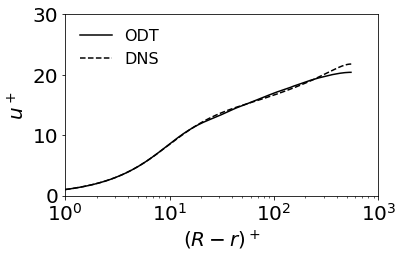

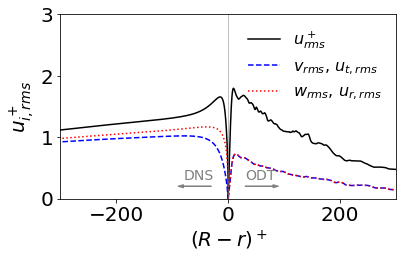

In [5]:
import numpy as np
import glob as gb
import yaml
import sys
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
from scipy.interpolate import interp1d

#--------------------------------------------------------------------------------------------

if not os.path.exists("../../data/"+caseN+"/post") :
    os.mkdir("../../data/"+caseN+"/post")

#-----------------------------------

with open("../../data/"+caseN+"/input/input.yaml") as ifile :
    yml = yaml.load(ifile, Loader=yaml.FullLoader)
kvisc = yml["params"]["kvisc0"]
dxmin = yml["params"]["dxmin"]
delta = yml["params"]["domainLength"] * 0.5
Retau = 1.0/kvisc

flist = sorted(gb.glob('../../data/'+caseN+'/data/data_00000/dmp_*.dat'))

nunif  = int(1/dxmin)        # uniform grid (using smallest grid size)   
nunif2 = int(nunif/2)        # half as many (for ploting to domain center)

nfiles = len(flist)
yu = np.linspace(-delta,delta,nunif)
um  = np.zeros(nunif)        # mean velocity
u2m = np.zeros(nunif)        # mean square velocity (for rms)
vm  = np.zeros(nunif)
v2m = np.zeros(nunif)
wm  = np.zeros(nunif)
w2m = np.zeros(nunif)

for ifile in flist :

    data = np.loadtxt(ifile);
    y = data[:,0]
    u = data[:,2]
    v = data[:,3]
    w = data[:,4]

    uu = interp1d(y, u, fill_value='extrapolate')(yu)  # interpolate to uniform grid
    vv = interp1d(y, v, fill_value='extrapolate')(yu)
    ww = interp1d(y, w, fill_value='extrapolate')(yu)

    um += uu                 # update mean profiles
    vm += vv
    wm += ww
    u2m += uu*uu
    v2m += vv*vv
    w2m += ww*ww

um /= nfiles
vm /= nfiles
wm /= nfiles
um = 0.5*(um[:nunif2] + np.flipud(um[nunif2:]))  # mirror data (symmetric)
vm = 0.5*(vm[:nunif2] + np.flipud(vm[nunif2:]))
wm = 0.5*(wm[:nunif2] + np.flipud(wm[nunif2:]))

u2m /= nfiles
v2m /= nfiles
w2m /= nfiles
u2m = 0.5*(u2m[:nunif2] + np.flipud(u2m[nunif2:]))
v2m = 0.5*(v2m[:nunif2] + np.flipud(v2m[nunif2:]))
w2m = 0.5*(w2m[:nunif2] + np.flipud(w2m[nunif2:]))

urms = np.sqrt(u2m - um*um)
vrms = np.sqrt(v2m - vm*vm)
wrms = np.sqrt(w2m - wm*wm)

yu += delta         # domain center is at 0; shift so left side is zero
yu = yu[:nunif2]    # plotting to domain center

dudy = (um[1]-um[0])/(yu[1]-yu[0])
utau = np.sqrt(kvisc * np.abs(dudy))
RetauOdt = utau * delta / kvisc

yu *= utau/kvisc    # scale y --> y+ (note: utau should be unity)

odt_data = np.vstack([yu,um,vm,wm,urms,vrms,wrms]).T
fname = "../../data/"+caseN+"/post/ODTstat.dat"
np.savetxt(fname, odt_data, header="y+, u+_mean, v+_mean, w+_mean, u+_rms, v+_rms, w+_rms", fmt='%12.5E')

print("Nominal Retau: ", Retau)
print("Actual  Retau: ", RetauOdt)

#--------------------------------------------------------------------------------------------

print(f"MAKING PLOT OF MEAN U PROFILE: ODT vs DNS in ../../data/{caseN}/post/u_mean.pdf" )
dns = np.loadtxt("DNS_raw/550_Re_1.dat", comments='%')
odt = np.loadtxt("../../data/"+caseN+"/post/ODTstat.dat")

matplotlib.rcParams.update({'font.size':20, 'figure.autolayout': True}) #, 'font.weight':'bold'})

fig, ax = plt.subplots()

y_odt = odt[:,0]
y_dns = dns[:,1]

u_odt = odt[:,1]
u_dns = dns[:,2]

ax.semilogx(y_odt, u_odt, 'k-',  label=r'ODT')
ax.semilogx(y_dns, u_dns, 'k--', label=r'DNS')

ax.set_xlabel(r'$(R-r)^+$') #, fontsize=22)
ax.set_ylabel(r'$u^+$') #, fontsize=22)
ax.legend(loc='upper left', frameon=False, fontsize=16)
ax.set_ylim([0, 30])
ax.set_xlim([1, 1000])

plt.savefig(f"../../data/{caseN}/post/u_mean.pdf")

#--------------------------------------------------------------------------------------------

print(f"MAKING PLOT OF RMS VEL PROFILES: ODT vs DNS in ../../data/{caseN}/post/u_rms.pdf" )
dns = np.loadtxt("DNS_raw/550_Re_1.dat", comments='%')
odt = np.loadtxt("../../data/"+caseN+"/post/ODTstat.dat")

matplotlib.rcParams.update({'font.size':20, 'figure.autolayout': True}) #, 'font.weight':'bold'})

fig, ax = plt.subplots()

y_odt = odt[:,0]
y_dns = dns[:,1]

urms_odt = odt[:,4]
vrms_odt = odt[:,5]
wrms_odt = odt[:,6]

urms_dns = dns[:,6]**0.5
vrms_dns = dns[:,4]**0.5
wrms_dns = dns[:,5]**0.5

ax.plot(y_odt, urms_odt, 'k-',  label=r'$u_{rms}^+$')
ax.plot(y_odt, vrms_odt, 'b--', label=r'$v_{rms}$, $u_{t,rms}$')
ax.plot(y_odt, wrms_odt, 'r:',  label=r'$w_{rms}$, $u_{r,rms}$')

ax.plot(-y_dns, urms_dns, 'k-',  label='')
ax.plot(-y_dns, vrms_dns, 'b--', label='')
ax.plot(-y_dns, wrms_dns, 'r:',  label='')

ax.plot([0,0], [0,3], 'k-', linewidth=0.5, color='gray')
ax.arrow( 30,0.2,  50, 0, head_width=0.05, head_length=10, color='gray')
ax.arrow(-30,0.2, -50, 0, head_width=0.05, head_length=10, color='gray')
ax.text( 30,0.3,"ODT", fontsize=14, color='gray')
ax.text(-80,0.3,"DNS", fontsize=14, color='gray')

ax.set_xlabel(r'$(R-r)^+$') #, fontsize=22)
ax.set_ylabel(r'$u_{i,rms}^+$')
ax.legend(loc='upper right', frameon=False, fontsize=16)
ax.set_xlim([-300, 300])
ax.set_ylim([0, 3])

plt.savefig(f"../../data/{caseN}/post/u_rms.pdf")
